<a href="https://colab.research.google.com/github/e-saidha/credit_card_fraud_detection/blob/main/model_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries & loading the dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBRegressor

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'credit-card-transactions-dataset' dataset.
Path to dataset files: /kaggle/input/credit-card-transactions-dataset


In [ ]:
import os
path1 = os.listdir(path)


In [ ]:
df = pd.read_csv(f'{path}/{path1[0]}')

In [ ]:
df[df['is_fraud']==1]['amt'].sum()

np.float64(3988088.61)

Velocity burst feauture engineering

Defining buckets

In [ ]:
bins = [0, 1, 10, 50, 100, 500, 2000, 10000, df['amt'].max()]
labels = ['0–1', '1–10', '10–50', '50–100', '100–500', '500–2000', '2000–10k', '10k+']
df['amt_buck'] = pd.cut(df['amt'], bins=bins, labels=labels, include_lowest=True)


In [ ]:
def time_bucket(h):
    if 0 <= h < 4:
        return 'Late Night'
    elif 4 <= h < 7:
        return 'Early Morning'
    elif 7 <= h < 12:
        return 'Morning'
    elif 12 <= h < 16:
        return 'Afternoon'
    elif 16 <= h < 20:
        return 'Evening'
    else:
        return 'Night'

In [ ]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['hour_buck'] = df['hour'].apply(time_bucket)

Sorting all values as per cc

In [ ]:
df = df.sort_values(['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

In [ ]:
df =df.set_index('trans_date_trans_time', drop=False)

Creating rolling windows

In [ ]:
df['txn_1h'] = df.groupby('cc_num')['trans_num'].rolling('60min').count().reset_index(level=0, drop=True)
df['txn_10min'] = df.groupby('cc_num')['trans_num'].rolling('10min').count().reset_index(level=0, drop=True)
df['txn_24h'] = df.groupby('cc_num')['trans_num'].rolling('24h').count().reset_index(level=0, drop=True)
df['avg_amt'] = df.groupby('cc_num')['amt'].rolling(window=10, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
df = df.reset_index(drop=True)

Geolocation feature engineering

In [ ]:
def haversine(lat1,lon1,lat2,lon2):
  R=6371
  lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])
  dlat = lat2-lat1
  dlon = lon2-lon1
  a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
  return 2 * R * np.arcsin(np.sqrt(a))

In [ ]:
df = df.sort_values(['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

df['prev_merch_lat'] = df.groupby('cc_num')['merch_lat'].shift(1)
df['prev_merch_long'] = df.groupby('cc_num')['merch_long'].shift(1)
df['prev_time'] = df.groupby('cc_num')['trans_date_trans_time'].shift(1)

df['dist_km'] = haversine(df['prev_merch_lat'], df['prev_merch_long'],
                          df['merch_lat'], df['merch_long'])

In [ ]:
df['time_diff_sec'] = (df['trans_date_trans_time'] - df['prev_time']).dt.total_seconds()


In [ ]:
df['speed_kmph'] = df['dist_km'] / (df['time_diff_sec'] / 3600)


In [ ]:
df['dist_km'] = df['dist_km'].fillna(0)
df['speed_kmph'] = df['speed_kmph'].replace([np.inf, -np.inf], np.nan).fillna(0)


Creating Flags

In [ ]:
df['flag_impossible_travel'] = (df['speed_kmph'] > 1000).astype(int)
df['flag_long_distance'] = (df['dist_km'] > 100).astype(int)
df['flag_velocity_burst'] = (df['txn_10min'] >= 3).astype(int)
flag_summary = df.groupby(['flag_impossible_travel','flag_long_distance','flag_velocity_burst'])['is_fraud'].mean()
print(flag_summary.sort_values(ascending=False))


flag_impossible_travel  flag_long_distance  flag_velocity_burst
1                       1                   1                      0.073218
0                       0                   1                      0.069124
1                       0                   1                      0.067449
0                       1                   1                      0.040000
1                       0                   0                      0.022628
                        1                   0                      0.020383
0                       0                   0                      0.005695
                        1                   0                      0.005190
Name: is_fraud, dtype: float64


In [ ]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode', 'amt_buck',
       'hour', 'hour_buck', 'txn_1h', 'txn_10min', 'txn_24h', 'avg_amt',
       'prev_merch_lat', 'prev_merch_long', 'prev_time', 'dist_km',
       'time_diff_sec', 'speed_kmph', 'flag_impossible_travel',
       'flag_long_distance', 'flag_velocity_burst'],
      dtype='object')

In [ ]:
df = pd.get_dummies(df, columns=['hour_buck'], drop_first=True,dtype=int)

In [ ]:
features = [
    'amt', 'avg_amt',
    'txn_10min', 'txn_1h', 'txn_24h',
    'dist_km', 'speed_kmph',
    'flag_velocity_burst', 'flag_long_distance', 'flag_impossible_travel',
    'hour_buck_Early Morning', 'hour_buck_Evening',
       'hour_buck_Late Night', 'hour_buck_Morning', 'hour_buck_Night']
target = 'is_fraud'

In [ ]:
df = df.dropna(subset=['avg_amt'])

In [ ]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (907671, 15)
Test shape: (389003, 15)


Scaler

In [ ]:
num_cols = ['amt','avg_amt','txn_10min','txn_1h','txn_24h','dist_km','speed_kmph']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))



Classification Report:
              precision    recall  f1-score   support

           0      0.999     0.949     0.974    386751
           1      0.093     0.897     0.169      2252

    accuracy                          0.949    389003
   macro avg      0.546     0.923     0.572    389003
weighted avg      0.994     0.949     0.969    389003

ROC-AUC: 0.9747103325548803


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]


print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))



Random Forest Report:
              precision    recall  f1-score   support

           0      1.000     0.961     0.980    386751
           1      0.122     0.929     0.216      2252

    accuracy                          0.961    389003
   macro avg      0.561     0.945     0.598    389003
weighted avg      0.994     0.961     0.976    389003

ROC-AUC: 0.9861293941251151


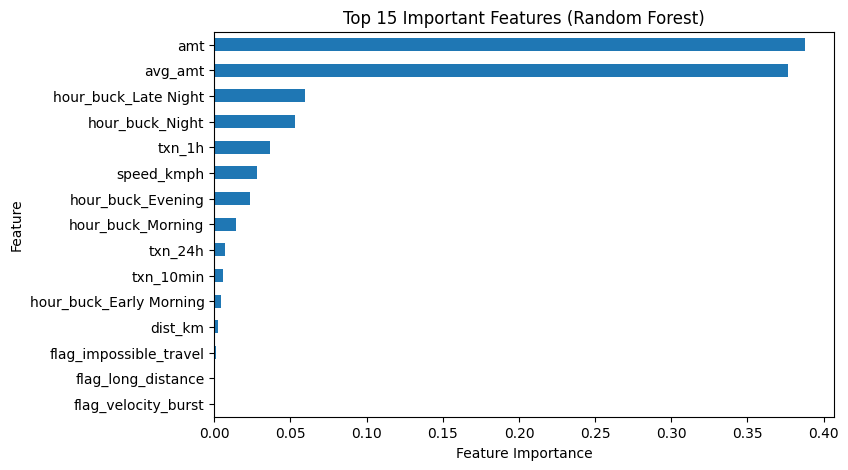

In [ ]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
top_features.plot(kind='barh')
plt.title("Top 15 Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()
